# Stable Voting

Code for testing examples from the paper [Stable Voting](https://arxiv.org/abs/2108.00542) by W. Holliday and E. Pacuit.  

In [138]:
# import the Profile class
from voting.profiles import *

# import the voting methods
from voting.voting_methods import *

from voting.generate_profiles import *
import math
import pandas as pd
from itertools import product, combinations

from functools import partial
from multiprocess import Pool, cpu_count
import pickle
import timeit

import copy
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()


In [139]:
def display_mg(mg): 
    
    pos = nx.circular_layout(mg)
    nx.draw(mg, pos, 
            font_size=20, font_color='white', node_size=700, 
            width=1.5, with_labels=True)
    labels = nx.get_edge_attributes(mg,'weight')
    nx.draw_networkx_edge_labels(mg,pos,edge_labels=labels, font_size=14, label_pos=0.3)
    plt.show()


Stable Voting (SV) selects a winner as follows:

1. If only one candidate $a$ appears on all ballots, then $a$ wins.
2. Otherwise list all head-to-head matches of the form $a$ vs. $b$ in order from the largest to smallest margin of $a$ vs. $b$. Find the first match $a$ vs. $b$ in the list such that $A$ wins according to Stable Voting *after $b$ is removed from all ballots*; this $a$ is the winner for the original set of ballots.  

Note that if there are two matches $a$ vs. $b$ and $a'$ vs. $b'$ with the same margins such that $a$ wins after $b$ is removed from the ballots, and $a'$ wins after $b'$ is removed from the ballots, then $a$ and $a'$ are tied Stable Voting winners for the original set of ballots.


In [140]:
# This code is available in voting/voting_methods.py but is included here for reference. 

def stable_voting_(profile, curr_cands = None, mem_sv_winners = {}): 
    '''
    Determine the Stable Voting winners for the profile while keeping track 
    of the winners in any subprofiles checked during computation. 
    '''
    
    # curr_cands is the set of candidates who have not been removed
    curr_cands = curr_cands if not curr_cands is None else profile.candidates
    sv_winners = list()
    
    matches = [(a, b) for a in curr_cands for b in curr_cands 
               if a != b]
    margins = list(set([profile.margin(a, b) for a,b in matches]))
        
    if len(curr_cands) == 1: 
        mem_sv_winners[tuple(curr_cands)] = curr_cands
        return curr_cands, mem_sv_winners
    for m in sorted(margins, reverse=True):
        for a, b in [ab_match for ab_match in matches 
                     if profile.margin(ab_match[0], ab_match[1])  == m]:
            if a not in sv_winners: 
                cands_minus_b = sorted([c for c in curr_cands if c!= b])
                if tuple(cands_minus_b) not in mem_sv_winners.keys(): 
                    ws, mem_sv_winners = stable_voting_(profile, 
                                                        curr_cands = [c for c in curr_cands if c != b],
                                                        mem_sv_winners = mem_sv_winners)
                    mem_sv_winners[tuple(cands_minus_b)] = ws
                else: 
                    ws = mem_sv_winners[tuple(cands_minus_b)]
                if a in ws:
                    sv_winners.append(a)
        if len(sv_winners) > 0: 
            return sorted(sv_winners), mem_sv_winners
        
@vm_name("Stable Voting")
def stable_voting(profile): 
    
    return stable_voting_(profile, curr_cands = None, mem_sv_winners = {})[0]


## Example 1

The following is an example with a Condorcet winner ($B$) where the Instant Runoff winner ($A$) and the Plurality winners ($A$ and $C$) are different than the SV winner ($B$). 

+---+---+---+
| 2 | 1 | 2 |
+---+---+---+
| A | B | C |
| B | A | B |
| C | C | A |
+---+---+---+


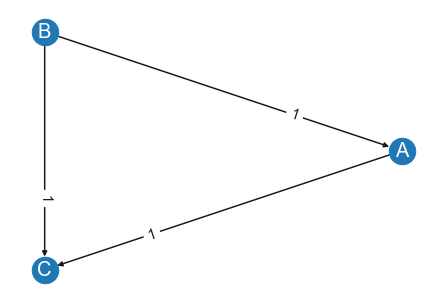

Instant Runoff winner: A
Plurality winners: A, C
Stable Voting winner: B
Condorcet winner: B


In [141]:
A = 0
B = 1 
C = 2

cmap = {A: "A", B: "B", C: "C" }
prof = Profile([
    (A, B, C),
    (B, A, C), 
    (C, B, A)
], 3, [2, 1, 2], cmap=cmap)

prof.display()

prof.display_margin_graph()
display_winners(prof, instant_runoff)
display_winners(prof, plurality)
display_winners(prof, stable_voting)
display_winners(prof, condorcet)


## Example 2

The following is an example without a Condorcet winner where the Instant Runoff winner ($D$) and the Plurality winners ($C$ and $D$),  and the Beat Path and Ranked Pairs winners ($B$, $C$ and $D$) are all different than the SV winner ($B$). 

+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| C | D | D | B |
| B | A | B | D |
| A | C | A | A |
| D | B | C | C |
+---+---+---+---+


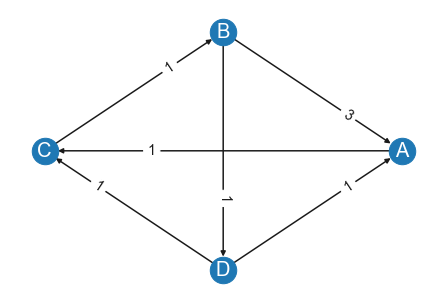

Instant Runoff winner: D
Plurality winners: C, D
Stable Voting winner: B
Beat Path winners: B, C, D
Ranked Pairs winners: B, C, D


In [142]:
A = 0
B = 1 
C = 2
D = 3

cmap = {A: "A", B: "B", C: "C", D: "D" }
prof = Profile([
    (C, B, A, D),
    (D, A, C, B), 
    (D, B, A, C),
    (B, D, A, C)
], 4, [2, 1, 1, 1], cmap=cmap)


prof.display()

prof.display_margin_graph()
display_winners(prof, instant_runoff)
display_winners(prof, plurality)
display_winners(prof, stable_voting)
display_winners(prof, beat_path_faster)
display_winners(prof, ranked_pairs)


## Example 3

A different profile generating the same margin graph as in Example 2 above. This is an example without a Condorcet winner where the Instant Runoff winner ($C$), the Plurality winners ($B$ and $C$), and the Beat Path and Ranked Pairs winners ($B$, $C$ and $D$) are all different than the SV winner ($B$).

+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| A | B | C | C | B |
| D | D | B | D | A |
| C | A | D | B | D |
| B | C | A | A | C |
+---+---+---+---+---+


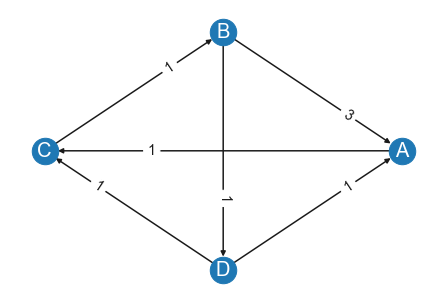

Instant Runoff winner: C
Plurality winners: B, C
Stable Voting winner: B
Beat Path winners: B, C, D
Ranked Pairs winners: B, C, D


In [143]:
A = 0
B = 1 
C = 2
D = 3

cmap = {A: "A", B: "B", C: "C", D: "D" }
prof = Profile([
    (A, D, C, B),
    (B, D, A, C),
    (C, B, D, A),
    (C, D, B, A), 
    (B, A, D, C)
], 4, [1, 1, 1, 1, 1], cmap=cmap)

prof.display()

prof.display_margin_graph()
display_winners(prof, instant_runoff)
display_winners(prof, plurality)
display_winners(prof, stable_voting)
display_winners(prof, beat_path_faster)
display_winners(prof, ranked_pairs)


## Example 4

An example in which the Ranked Pairs winners ($D$) is different than the Beat Path winners ($A$ and $D$), and both differ from the Stable Voting winner ($A$).

+---+---+---+---+---+---+---+---+
| 2 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+
| D | A | B | A | D | A | C | C |
| A | C | D | B | A | D | B | A |
| C | B | A | D | B | C | D | B |
| B | D | C | C | C | B | A | D |
+---+---+---+---+---+---+---+---+


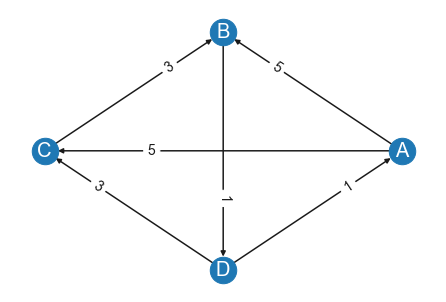

Instant Runoff winner: D
Plurality winners: A, D
Beat Path winners: A, D
Ranked Pairs winner: D
Stable Voting winner: A


In [144]:
A = 0
B = 1 
C = 2
D = 3

cmap = {A: "A", B: "B", C: "C", D: "D" }
prof = Profile([
    (D, A, C, B),
    (A, C, B, D), 
    (B, D, A, C),
    (A, B, D, C), 
    (D, A, B, C), 
    (A, D, C, B), 
    (C, B, D, A), 
    (C, A, B, D)
], 4, [2, 1, 1, 1, 1, 1, 1, 1], cmap=cmap)

prof.display()

prof.display_margin_graph()
display_winners(prof, instant_runoff)
display_winners(prof, plurality)
display_winners(prof, beat_path_faster)
display_winners(prof, ranked_pairs)
display_winners(prof, stable_voting)


In [145]:
# This code is available in voting/voting_methods.py but is included here for reference. 

def get_margin(mg, a, b): 
    '''get the margin of a over b in the marging graph mg'''
    m = 0.0
    
    if mg.has_edge(a, b): 
        m = mg.get_edge_data(a, b)['weight'] 
    elif mg.has_edge(b, a):
        m = -1 * mg.get_edge_data(b, a)['weight'] 
    return m

@vm_name("Stable Voting")
def stable_voting_mg_(mg, curr_cands = None, mem_sv_winners = {}): 
    '''
    Determine the Stable Voting winners for the margin graph mg while keeping track 
    of the winners in any subprofiles checked during computation. 
    '''
    
    # curr_cands is the set of candidates who have not been removed
    curr_cands = curr_cands if not curr_cands is None else mg.nodes 
    sv_winners = list()

    matches = [(a, b) for a in curr_cands for b in curr_cands 
               if a != b]
    margins = list(set([get_margin(mg, a, b) for a,b in matches]))
    
    if len(curr_cands) == 1: 
        mem_sv_winners[tuple(curr_cands)] = curr_cands
        return curr_cands, mem_sv_winners
    for m in sorted(margins, reverse=True):
        for a, b in [ab_match for ab_match in matches 
                     if get_margin(mg, ab_match[0], ab_match[1]) == m]:
            if a not in sv_winners: 
                cands_minus_b = sorted([c for c in curr_cands if c!= b])
                if tuple(cands_minus_b) not in mem_sv_winners.keys(): 
                    ws, mem_sv_winners = stable_voting_mg_(mg, 
                                                           curr_cands = [c for c in curr_cands if c != b],
                                                           mem_sv_winners = mem_sv_winners )
                    mem_sv_winners[tuple(cands_minus_b)] = ws
                else: 
                    ws = mem_sv_winners[tuple(cands_minus_b)]
                if a in ws:
                    sv_winners.append(a)
        if len(sv_winners) > 0: 
            return sorted(sv_winners), mem_sv_winners
                
@vm_name("Stable Voting")
def stable_voting_mg(mg): 
    
    return stable_voting_mg_(mg, curr_cands = None, mem_sv_winners = {})[0]


## Example 3.4 and 3.5

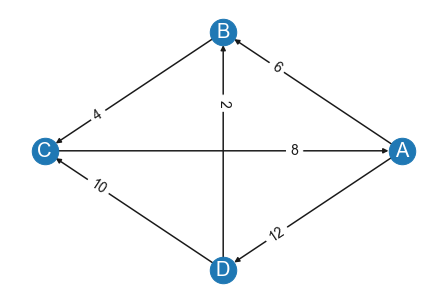

Stable Voting Winners: A
Beat Path Winners: A
Ranked Pairs Winners: A



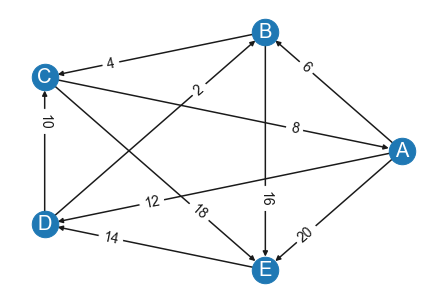

Stable Voting Winners: A
Beat Path Winners: B
Ranked Pairs Winners: C


In [146]:

A = "A"
B = "B"
C = "C"
D = "D"
mg = nx.DiGraph()
mg.add_nodes_from([A, B, C, D])
mg.add_weighted_edges_from([
    (A, B, 6),
    (A, D, 12),
    (B, C, 4), 
    (C, A, 8), 
    (D, B, 2),
    (D, C, 10)
])

display_mg(mg)
print("Stable Voting Winners:",  ', '.join(stable_voting_mg(mg)))
print("Beat Path Winners:",  ', '.join(beat_path_mg(mg)))
print("Ranked Pairs Winners:",  ', '.join(ranked_pairs_mg(mg)))

print("")

A = "A"
B = "B"
C = "C"
D = "D"
E = "E"

mg = nx.DiGraph()
mg.add_nodes_from([A, B, C, D])
mg.add_weighted_edges_from([
    (A, B, 6),
    (A, D, 12),
    (B, C, 4), 
    (C, A, 8), 
    (D, B, 2),
    (D, C, 10),
    (A, E, 20), 
    (B, E, 16), 
    (C, E, 18), 
    (E, D, 14)
])

display_mg(mg)
print("Stable Voting Winners:",  ', '.join(stable_voting_mg(mg)))
print("Beat Path Winners:",  ', '.join(beat_path_mg(mg)))
print("Ranked Pairs Winners:",  ', '.join(ranked_pairs_mg(mg)))



## Running Time

In [147]:
@vm_name("Stable Voting Faster")
def stable_voting_faster(profile): 
    '''First check if there is a Condorcet winner.  If so, return the Condorcet winner, otherwise 
    find the stable voting winnner using stable_voting_'''
    cw = profile.condorcet_winner()
    
    if cw is not None: 
        return [cw]
    else: 
        return stable_voting_(profile, curr_cands = None, mem_sv_winners = {})[0]


In [148]:

SKIP_TEST = True # set to false to re-run tests, but this takes a long time. 


if not SKIP_TEST: 

    import time

    data_for_df = { 
        "num_cands": [],
        "pm": [],
        "sv_avg_running_time": [],
        "sv_faster_avg_running_time": [],
        "percent_cw": []
    }

    data_for_df2 = { 
        "num_cands": [],
        "pm": [],
        "sv_running_time": [],
        "sv_faster_running_time": [],
    }



    prob_mods = [
       "IC", 
        "URN-R", 
        "MALLOWS-R",
        "MALLOWS-RELPHI-R",
        "SinglePeaked",

    ]

    all_num_cands = list(range(3, 22))

    num_voters = 500

    num_trials = 5#00

    cpus= cpu_count()
    print(cpus)
    pool = Pool(12)

    def record_data(num_cands, num_voters, pm, t): 

        prof = generate_profile(num_cands, num_voters, probmod=pm)

        s = time.time()
        sv = stable_voting(prof)
        e = time.time()
        sv_running_time = e - s

        s = time.time()
        stable_voting_faster(prof)
        e = time.time()

        sv_faster_running_time = e - s

        cw = prof.condorcet_winner()

        return {
            "sv_running_time": sv_running_time,
            "sv_faster_running_time": sv_faster_running_time,
            "cw": cw is not None
        }


    for pm in prob_mods:
        print(pm)
        for num_cands in all_num_cands:
            print("\t",num_cands)


            record_data_even = partial(record_data, num_cands, num_voters, pm)
            record_data_odd = partial(record_data, num_cands, num_voters + 1, pm)

            data_even = pool.map(record_data_even, range(num_trials))
            data_odd = pool.map(record_data_odd, range(num_trials))


            data = data_even + data_odd

            for d in data: 
                data_for_df2["sv_running_time"].append(d["sv_running_time"])
                data_for_df2["sv_faster_running_time"].append(d["sv_faster_running_time"])
                data_for_df2["num_cands"].append(num_cands)
                data_for_df2["pm"].append(pm)

            data_for_df["num_cands"].append(num_cands)
            data_for_df["pm"].append(pm)
            data_for_df["sv_avg_running_time"].append(np.average([d["sv_running_time"] for d in data]))
            data_for_df["sv_faster_avg_running_time"].append(np.average([d["sv_faster_running_time"] for d in data]))
            data_for_df["percent_cw"].append(len([d for d in data if d["cw"]]) / len(data))

            print(data_for_df)
            df = pd.DataFrame(data_for_df)
            df.to_csv(f"./python_running_times.csv", index=False)
            df2 = pd.DataFrame(data_for_df2)
            df2.to_csv(f"./python_running_times_all_times.csv", index=False)

    df


In [149]:
# read the pre-computed tests
df = pd.read_csv("./data/python_running_times2.csv")
df["num_cands"] = df["num_cands"].astype(str)

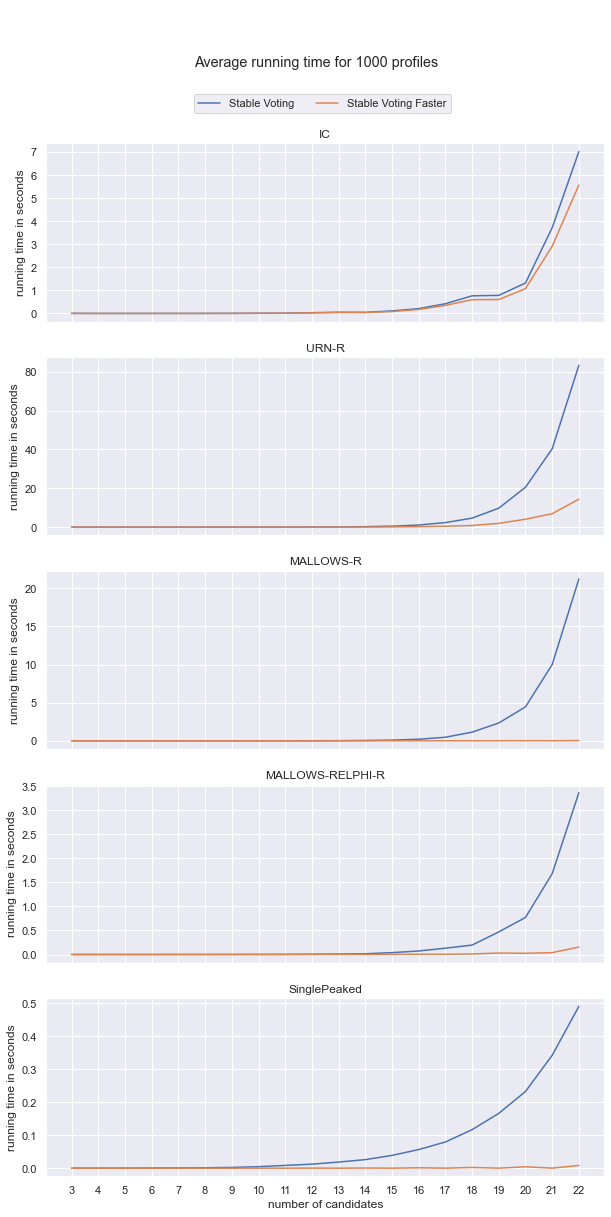

In [150]:
# running times for different probability models

pms = [
    'IC',
    'URN-R',
    'MALLOWS-R', 
    'MALLOWS-RELPHI-R', 
    'SinglePeaked'
]

fig, axs = plt.subplots(nrows=len(pms), sharex=True, figsize=(10,19))

for idx, pm in enumerate(pms): 
    ax = axs[idx]
    sns.lineplot(x="num_cands", y = "sv_avg_running_time", data =df[df["pm"] == pm], ax=ax, label="Stable Voting")
    sns.lineplot(x="num_cands", y = "sv_faster_avg_running_time", data =df[df["pm"] == pm], ax =ax, label="Stable Voting Faster")
    ax.set_ylabel("running time in seconds")
    ax.set_xlabel("number of candidates")
    ax.set_title(f"{pm}")
    ax.legend().set_visible(False)

plt.suptitle("\n\n\nAverage running time for 1000 profiles")
plt.legend(ncol=2,bbox_to_anchor=(0.495, 6.025), loc='center',
                borderaxespad=0.25)
plt.show()

In [151]:
# data for producing boxen plots of the running times

df_all_running_times = pd.read_csv("./data/python_running_times_all_times2.csv")
df_all_running_times["num_cands"] = df_all_running_times["num_cands"].astype(str)

In [152]:
def show_graph(pm): 
    fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
    sns.boxenplot(x="num_cands", y="sv_running_time", data=df_all_running_times[df_all_running_times["pm"] == pm], ax=axs[0])
    sns.boxenplot(x="num_cands", y="sv_faster_running_time", data=df_all_running_times[df_all_running_times["pm"] == pm],  ax=axs[1])
    axs[0].set_ylabel('Running time in seconds')
    axs[1].set_ylabel('Running time in seconds')
    axs[0].set_xlabel('Number of candidates')
    axs[1].set_xlabel('Number of candidates')
    axs[0].set_title("Stable Voting running times")
    axs[1].set_title("Stable Voting Faster running times")
    plt.subplots_adjust(wspace=0.05)
    plt.suptitle(f"Probability model: {pm}")
    plt.show()    

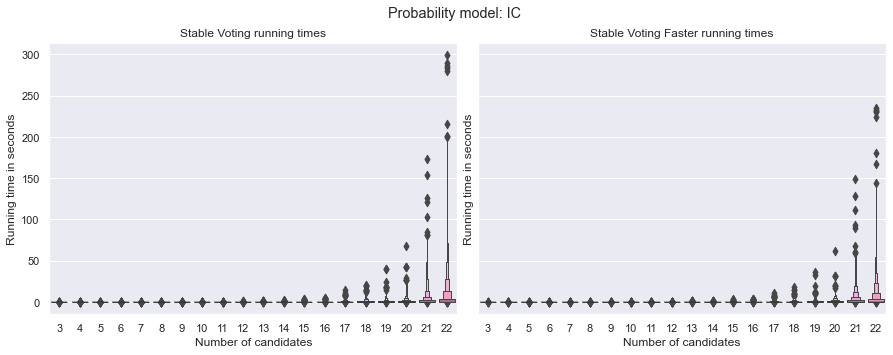

In [153]:
show_graph("IC")

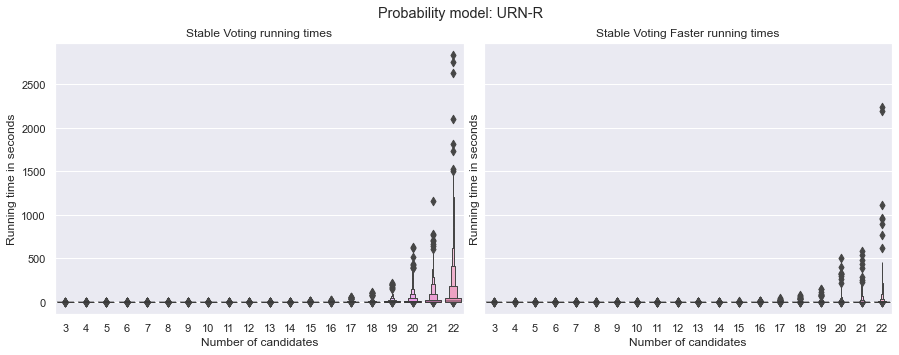

In [154]:
show_graph("URN-R")

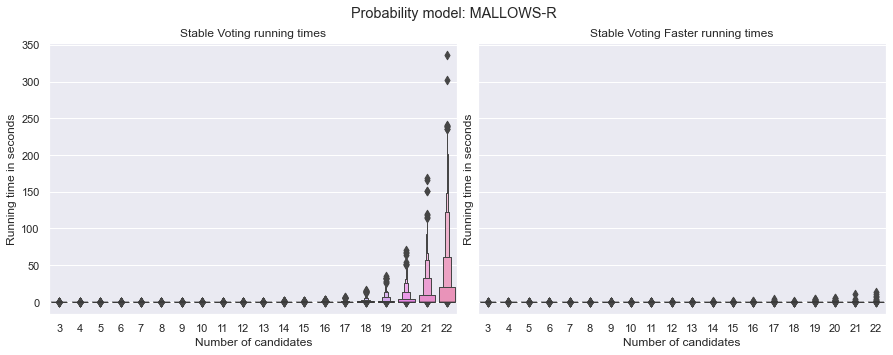

In [155]:
show_graph("MALLOWS-R")

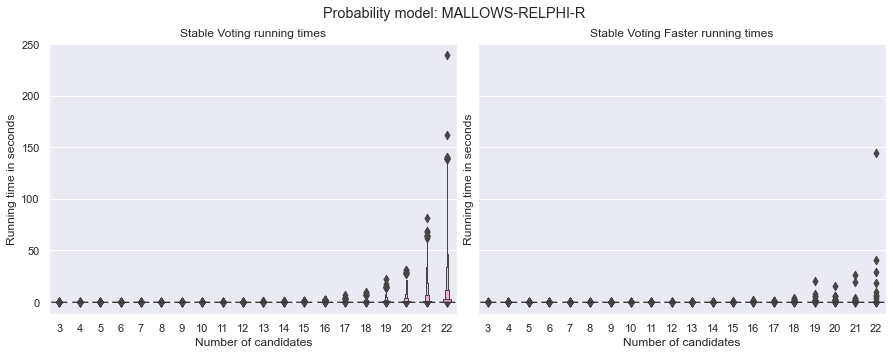

In [156]:
show_graph("MALLOWS-RELPHI-R")

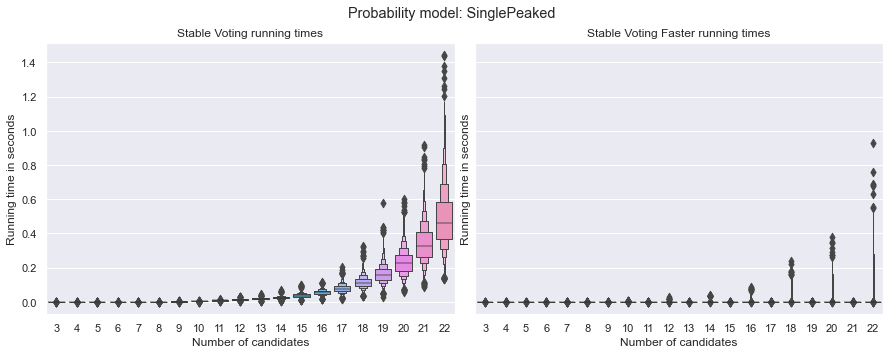

In [157]:
show_graph("SinglePeaked")